# Toy dataset demo

In [1]:
import skdim
import scanpy as sc
import sklearn
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geomstats, geomstats.visualization
from geomstats.learning import kmeans,frechet_mean,pca
from geomstats.geometry.hypersphere import Hypersphere
from subspace import Subspaces, neighbors, utils, grassmann_distances

INFO: Using numpy backend


Load data

In [2]:
X = np.loadtxt('../../git/elpigraph-python/data/tree_data.csv',delimiter=',')[:,[0,1]]
#X = np.hstack((X,np.random.random((len(X),2))/50))
#plt.scatter(*X[:,[0,1]].T);plt.show()
#
#ax=plt.subplot(projection='3d')
#ax.scatter(*X[:,[2,0,1]].T)
#ax.set_xlim(-1.2,1.2)
#ax.set_ylim(-1.2,1.2)
#ax.set_zlim(-1.2,1.2)
#plt.show()

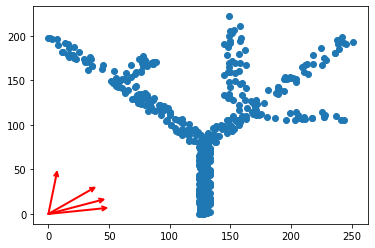

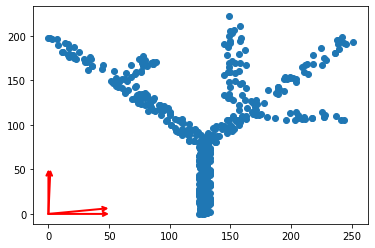

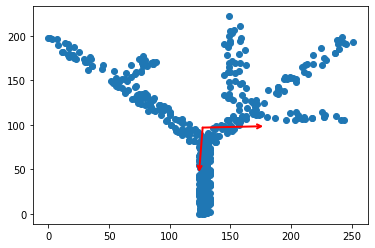

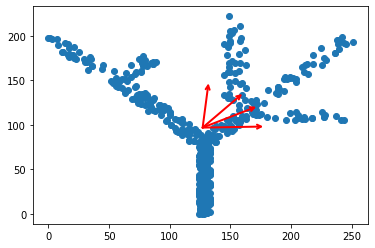

In [3]:
Xtopic=((X+2)*100).astype(int)
Xtopic-=Xtopic.min(axis=0)

mean = np.mean(Xtopic,0)[:2]

lda = sklearn.decomposition.LatentDirichletAllocation(n_components=4).fit(Xtopic)
lda_transform = lda.transform(Xtopic)
lda.components_ /= lda.components_.sum(axis=1,keepdims=1)

nmf = sklearn.decomposition.NMF(n_components=4).fit(Xtopic)
nmf_transform = nmf.transform(Xtopic)

ica=sklearn.decomposition.FastICA(n_components=4).fit(Xtopic)
ica_transform = ica.transform(Xtopic)

sdl=sklearn.decomposition.DictionaryLearning(n_components=4,fit_algorithm='cd').fit(Xtopic)
sdl_transform = sdl.transform(Xtopic)

plt.scatter(*Xtopic[:,:2].T)
for topic in lda.components_[:,:2]:
    topic_norm = 50 * topic/np.linalg.norm(topic) 
    utils.draw_vector(np.zeros(2),np.zeros(2)+topic_norm,c='r')
plt.show()
    
plt.scatter(*Xtopic[:,:2].T)
for topic in nmf.components_[:,:2]:
    topic_norm = 50 * topic/np.linalg.norm(topic) 
    utils.draw_vector(np.zeros(2),np.zeros(2)+topic_norm,c='r')
plt.show()

plt.scatter(*Xtopic[:,:2].T)
for topic in ica.components_[:,:2]:
    topic_norm = 50 * topic/np.linalg.norm(topic) 
    utils.draw_vector(mean,mean+topic_norm,c='r')
plt.show()

plt.scatter(*Xtopic[:,:2].T)
for topic in sdl.components_[:,:2]:
    topic_norm = 50 * topic/np.linalg.norm(topic) 
    utils.draw_vector(mean,mean+topic_norm,c='r')
plt.show()

Define a kNN graph


Vanilla kNN


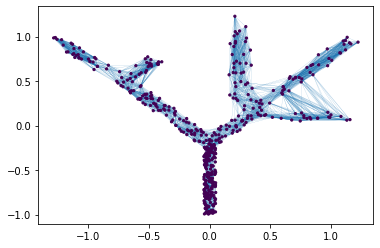


MNN


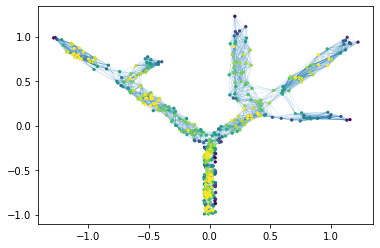


Auto kNN scale (entropy)


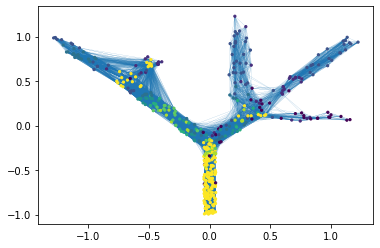

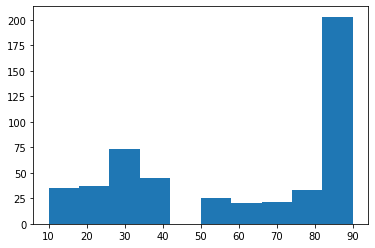


Auto rNN scale (entropy)


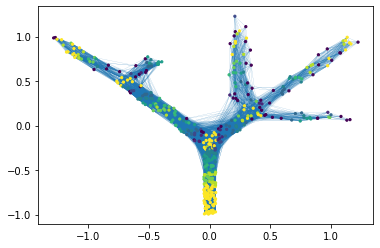

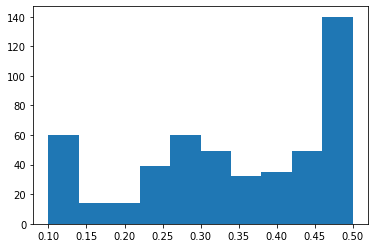


Auto rNN scale (global knee)


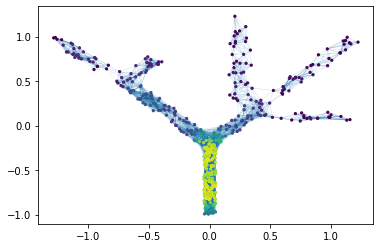

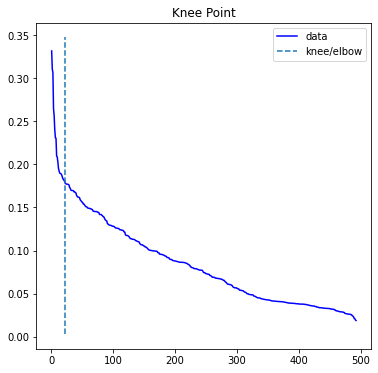

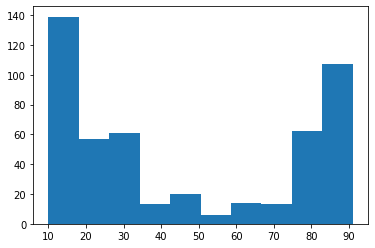


Auto geodesic kNN scale (entropy)


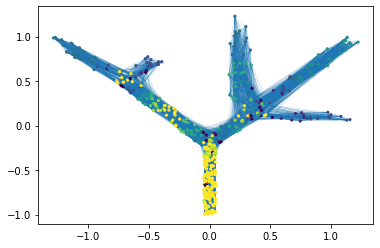

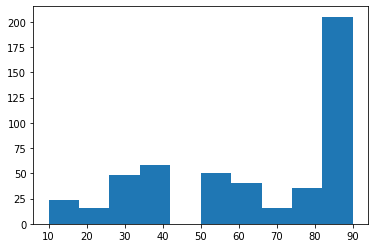


 geodesic MNN


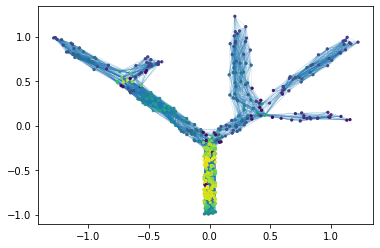

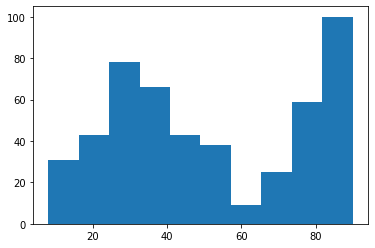

In [4]:
min_nn = 10
max_nn = min( int(len(X)*.2), 100 )
min_r = .1
max_r = .5

knn = sklearn.neighbors.NearestNeighbors(n_neighbors=max_nn,radius=max_r).fit(X)
knndis,knnidx = knn.kneighbors()
raddis,radidx = knn.radius_neighbors()

print('\nVanilla kNN')
k=25
neighbors.plot_nn_kscale(X[:,:2],knndis[:,:k],knnidx[:,:k],np.repeat(k,len(X)))

print('\nMNN')
mnndis,mnnidx = neighbors.mnn(knndis[:,:k],knnidx[:,:k],sparse=False)
neighbors.plot_nn_rscale(X[:,:2],mnndis,mnnidx,[len(x) for x in mnnidx])

print('\nAuto kNN scale (entropy)')
newdis, newidx, kscale, kentropies = neighbors.auto_knn(X,knndis,knnidx,min_nn=min_nn,max_nn=max_nn,plotX=X[:,:2])

print('\nAuto rNN scale (entropy)')
newdis, newidx, rscale, entropies = neighbors.auto_rnn(X,raddis,radidx,min_r=min_r,max_r=max_r,plotX=X[:,:2])

print('\nAuto rNN scale (global knee)')
newdis, newidx, radius, kneedle = neighbors.auto_rnn_knee(X,knndis,knnidx,force_nn=min_nn,min_nn=min_nn,max_nn=max_nn,plotX=X[:,:2])

print('\nAuto geodesic kNN scale (entropy)')
newdis, newidx, graphdis, graphidx, scale, entropies = neighbors.auto_knn_geo(X,knndis,knnidx,k=8, min_nn = min_nn,max_nn = max_nn,step = 10, plotX=X[:,:2])

print('\n geodesic MNN')
mnndis,mnnidx = neighbors.mnn(newdis,newidx,sparse=False)
neighbors.plot_nn_rscale(X[:,:2],mnndis,mnnidx,[len(x) for x in mnnidx])
plt.hist([len(x) for x in mnnidx]);plt.show()

Compute subspaces and distance between them

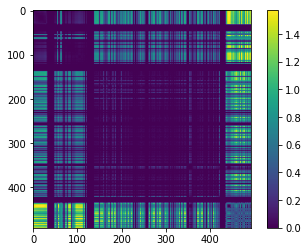

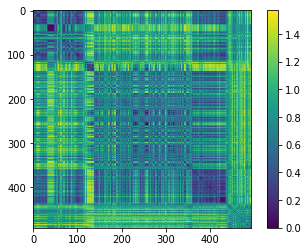

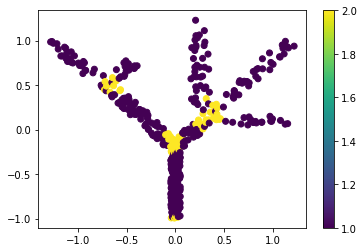

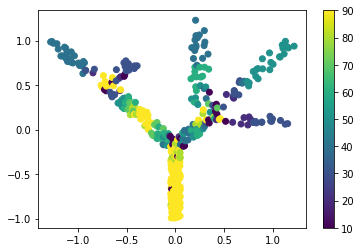

In [15]:
use_idx = mnnidx.copy()
subsample = False

lids = np.array([skdim.id.lPCA(alphaFO=.2).fit(X[idx]).dimension_ for idx in use_idx])

if subsample:    
    sel_idx,sel_part = utils.kmeans_centroids(X,n_clusters=100)
    use_idx_subsample = [use_idx[i] for i in sel_idx]
    
    subs = Subspaces.from_projection([X[ix] for ix in use_idx_subsample])
    subs.grassmann_distances(metric='geodesic',max_rank=1,contrast_unequal=False)
    sD = utils.squareform(subs.pdist_)
    D = utils.upsample_distance_matrix_squareform(sD,sel_part).toarray()
    
else:    
    subs = Subspaces.from_projection([X[ix] for ix in use_idx],ranks='auto')
    subs.grassmann_distances(metric='geodesic',gpu=True,contrast_unequal=False,max_rank=None,max_nbytes=1e8)
    D = utils.squareform(subs.pdist_)
    
subsaff = Subspaces.from_subspaces([utils.graff2grass(s,m)[1] for m,s in zip(subs.means_,subs.subspaces_)],)
subsaff.grassmann_distances(contrast_unequal=False,max_rank=2)
Daff = utils.squareform(subsaff.pdist_)

plt.imshow(D);plt.colorbar();plt.show()
plt.imshow(Daff);plt.colorbar();plt.show()
plt.scatter(*X[:,:2].T,c=lids);plt.colorbar();plt.show()
plt.scatter(*X[:,:2].T,c=scale);plt.colorbar();plt.show()

Cluster subspaces 

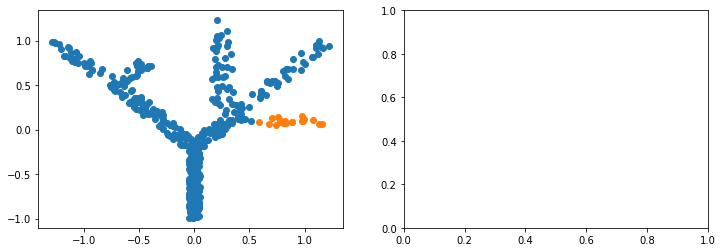

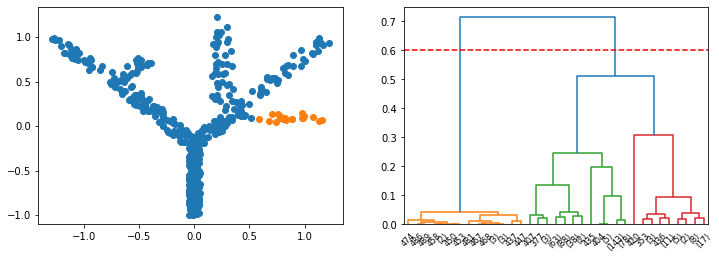

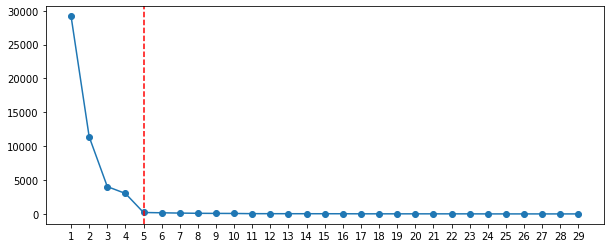

In [16]:
distance_threshold=.6

agg=sklearn.cluster.AgglomerativeClustering(n_clusters=None,
                                            distance_threshold=distance_threshold,
                                            affinity="precomputed",linkage='average',)
agg.fit(utils.squareform(subs.pdist_))

clus = agg.labels_
if subsample: clus = utils.upsample_labels(clus,sel_part)    
clus_smooth = utils.refine_clustering(clus,use_idx,k=10,min_size=0,smooth=True)

f,axs=plt.subplots(1,2,figsize=(12,4))
for ix in np.unique(clus): 
    axs[0].scatter(*X[clus==ix,:2].T)
plt.show()

f,axs=plt.subplots(1,2,figsize=(12,4))

for ix in np.unique(clus_smooth): 
    axs[0].scatter(*X[clus_smooth==ix,:2].T)

dendro=skdim.cluster.dendrogram(skdim.cluster.getLinkage(agg),truncate_mode='level',p=5,ax=axs[1])
axs[1].axhline(distance_threshold,c='r',linestyle='--')
plt.show()

n_clusters = utils.find_best_cut(D,agg.children_,agg.n_leaves_,max_clusters=30,plot=True,figsize=(10,4))

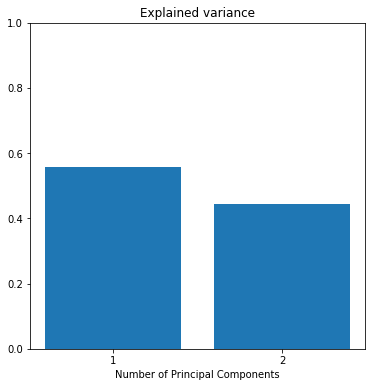

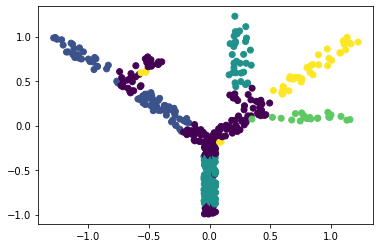

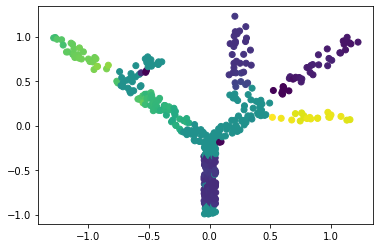

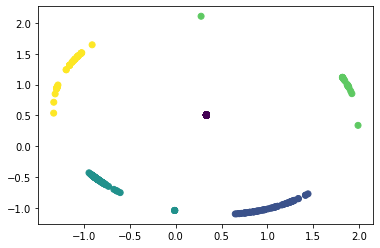

In [7]:
#conway embedding
#subs.flip_sign()
subs.embed_conway(normalize=True, max_rank=None)
nconemb = subs.subspaces_conway_

sphere = Hypersphere(dim=nconemb.shape[1]-1)

# kmeans
rkmeans = kmeans.RiemannianKMeans(sphere.metric, 5, tol=1e-3, init_step_size=1.0, init='kmeans++')
centroids = rkmeans.fit(nconemb)
labels = rkmeans.predict(nconemb)

# pga
n_components = 2
mean = frechet_mean.FrechetMean(metric=sphere.metric).fit(nconemb)
tpca = pca.TangentPCA(metric=sphere.metric, n_components=n_components).fit(nconemb, base_point=mean.estimate_)
X_tpca = tpca.transform(nconemb)
t = np.linspace(-1.0, 1.0, 100)
geodesic_points = []
for i in range(n_components):
    geodesic_points.append(sphere.metric.geodesic(
        initial_point=mean.estimate_, 
        initial_tangent_vec=tpca.components_[0])(t))

#f = plt.figure(figsize=(5,5))
##ax = f.add_subplot(projection='3d')
#ax = geomstats.visualization.plot(nconemb, space="S2", marker=".", color=None)
#ax = geomstats.visualization.plot(mean.estimate_, ax, space="S2", color="red", s=200, label="Fréchet mean")
#ax = geomstats.visualization.plot(geodesic_points_0, ax, space="S2", linewidth=2, label="First component")
#ax = geomstats.visualization.plot(geodesic_points_1, ax, space="S2", linewidth=2, label="Second component")
#ax.legend()
#ax.set_box_aspect([1, 1, 1])
#plt.show()


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
xticks = np.arange(1, tpca.n_components + 1, 1)
ax.xaxis.set_ticks(xticks)
ax.set_title("Explained variance")
ax.set_xlabel("Number of Principal Components")
ax.set_ylim((0, 1))
ax.bar(xticks, tpca.explained_variance_ratio_)
plt.show()

if subsample: labels = utils.upsample_labels(labels,sel_part) 
plt.scatter(*X[:,:2].T,c=labels);plt.show()
plt.scatter(*X[:,:2].T,c=X_tpca[:,[0]]);plt.show()
plt.scatter(*X_tpca[:,:2].T,c=labels);plt.show()

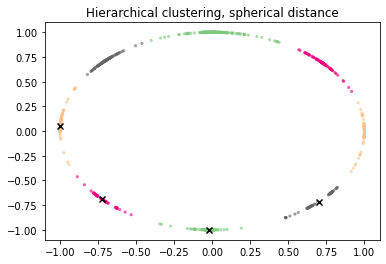

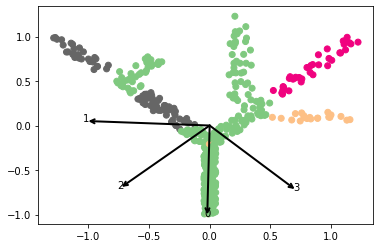

In [8]:
## topics
n_clusters = 4

subs_flat = subs.flatten()
subspaces_flat = np.concatenate(subs_flat.subspaces_,axis=1).T

#hierarchical clustering on angular distance matrix
subs_flat.grassmann_distances(metric='geodesic')
D_angular = np.rad2deg(utils.squareform(subs_flat.pdist_))

agg=sklearn.cluster.AgglomerativeClustering(n_clusters=n_clusters,affinity="precomputed",
                                             linkage='average',
                                             distance_threshold=None).fit(D_angular)
labels_agg = agg.labels_

centroids_agg = []
for c in np.unique(labels_agg):
    s = Subspaces.from_subspaces([subs_flat.subspaces_[i] for i in np.where(labels_agg==c)[0]])
    s.mean()
    centroids_agg.append(s.mean_[:,0])

centroids_agg = np.array(centroids_agg)


plt.scatter(*subspaces_flat[:,:2].T,c=labels_agg,s=5,alpha=.5,cmap=plt.cm.Accent)
plt.scatter(*centroids_agg[:,:2].T,marker='x',c='k')
plt.title('Hierarchical clustering, spherical distance')
plt.show()

subs_centroids = Subspaces.from_subspaces([c.reshape(-1,1) for c in centroids_agg])

D = subs_centroids.grassmann_distances(subs,contrast_unequal=False,return_angles=False)
Dsoft = scipy.special.softmax(-D,0)
clus = D.argmin(axis=0)

clus_smooth = utils.refine_clustering(clus,use_idx,k=10,min_size=0,smooth=True)

plt.scatter(*X[:,:2].T,c=clus_smooth,cmap=plt.cm.Accent)

for i,v in enumerate(subs_centroids.subspaces_):
    utils.draw_vector(np.zeros(2),np.zeros(2) + v[:2].flatten(),text=str(i))
plt.show()

[]

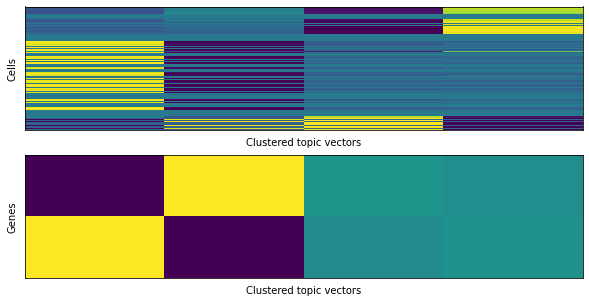

In [9]:
f,axs = plt.subplots(2,1,figsize=(10,5))

axs[0].imshow(Dsoft.T,aspect='auto',interpolation='none')
axs[0].set_xlabel('Clustered topic vectors')
axs[0].set_ylabel('Cells')
axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].imshow(np.hstack(subs_centroids.subspaces_)**2,aspect='auto',interpolation='none')
axs[1].set_xlabel('Clustered topic vectors')
axs[1].set_ylabel('Genes')
axs[1].set_xticks([])
axs[1].set_yticks([])

# SSC

In [16]:
%load_ext rpy2.ipython

In [23]:
import sys
sys.path.append('../../git/subspace-clustering/')

from cluster.selfrepresentation import ElasticNetSubspaceClustering, SparseSubspaceClusteringOMP
lids = np.array([skdim.id.lPCA(alphaFO=.2).fit(X[idx]).dimension_ for idx in use_idx])

clus_ensc={}
clus_ssc_omp={}
clus_msm = {}
clus_agg = {}
clus_agg_smooth = {}
clus_agg_auto = {}
clus_agg_auto_smooth = {}
for n_clusters in np.arange(4,8):
    subs = Subspaces.from_projection([X[ix] for ix in use_idx],ranks=lids)
    subs.grassmann_distances(metric='geodesic',gpu=True,contrast_unequal=False,max_rank=1,max_nbytes=1e8)
    agg=sklearn.cluster.AgglomerativeClustering(n_clusters=n_clusters,
                                                distance_threshold=None,
                                                affinity="precomputed",linkage='average',)
    agg.fit(utils.squareform(subs.pdist_))
    clus_agg[n_clusters] = agg.labels_
    clus_agg_smooth[n_clusters] = utils.refine_clustering(clus_agg[n_clusters],use_idx,k=8,min_size=0,smooth=True)
    
    subs.grassmann_distances(metric='geodesic',gpu=True,contrast_unequal=True,max_rank=None,max_nbytes=1e8)
    agg.fit(utils.squareform(subs.pdist_))
    clus_agg_auto[n_clusters] = agg.labels_
    clus_agg_auto_smooth[n_clusters] = utils.refine_clustering(clus_agg_auto[n_clusters],use_idx,k=8,min_size=0,smooth=True)
    
    model_ensc = ElasticNetSubspaceClustering(n_clusters=n_clusters)
    model_ssc_omp = SparseSubspaceClusteringOMP(n_clusters=n_clusters)
    output_msm = %R -i X -i n_clusters -o x x=T4cluster::MSM(X, k=n_clusters,iter=500)
    
    clus_msm[n_clusters] = output_msm[-1][3]
    clus_ensc[n_clusters]=model_ensc.fit_predict(X)
    clus_ssc_omp[n_clusters]=model_ssc_omp.fit_predict(X)

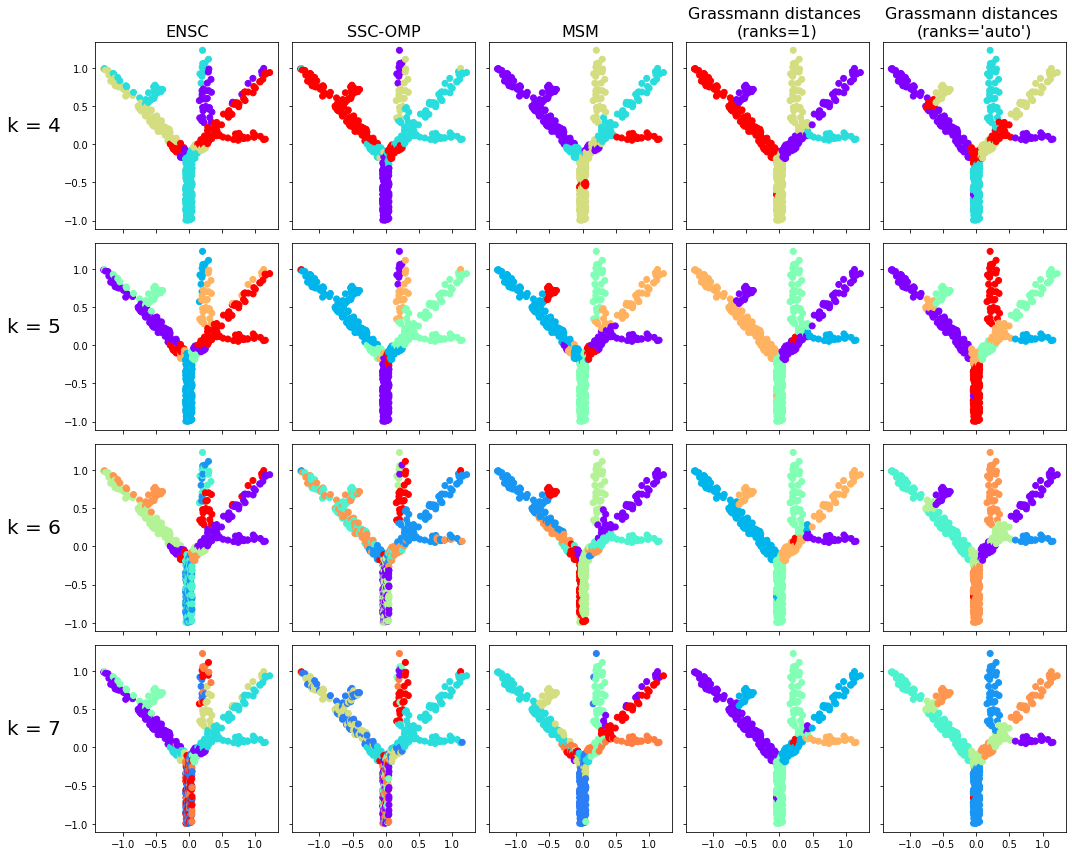

In [26]:
f,axs=plt.subplots(4,5,figsize=(15,12),sharex=True,sharey=True)
axs=axs.T
for i,n_clusters in enumerate(np.arange(4,8)):
    axs[0,i].scatter(*X[:,:2].T,c=clus_ensc[n_clusters],cmap='rainbow')
    axs[1,i].scatter(*X[:,:2].T,c=clus_ssc_omp[n_clusters],cmap='rainbow')
    axs[2,i].scatter(*X[:,:2].T,c=clus_msm[n_clusters],cmap='rainbow')
    axs[3,i].scatter(*X[:,:2].T,c=clus_agg_smooth[n_clusters],cmap='rainbow')
    axs[4,i].scatter(*X[:,:2].T,c=clus_agg_auto_smooth[n_clusters],cmap='rainbow')

    axs[0,i].set_ylabel(f'k = {n_clusters}',fontsize=20,rotation=0,labelpad=30)
axs[0,0].set_title('ENSC',fontsize=16)
axs[1,0].set_title('SSC-OMP',fontsize=16)
axs[2,0].set_title('MSM',fontsize=16)
axs[3,0].set_title('Grassmann distances \n(ranks=1)',fontsize=16)
axs[4,0].set_title("Grassmann distances \n(ranks='auto')",fontsize=16)

plt.tight_layout()
plt.savefig('../../git/PHD_THESIS/images/Local dimensionality/subspace_clustering.png',bbox_inches="tight",dpi=300)
plt.show()

In [2]:
import pickle
with open('data/Nestorowa.pkl','rb') as f:
    sdict = pickle.load(f)
adata_reordered=sdict['adata_reordered']
X_umap=sdict['X_umap']
X_diffmap=sdict['X_diffmap']
X_pca=sdict['X_pca']
X_pca_var=sdict['X_pca_var']

X=X_pca[:,:50]

min_nn = 10
max_nn = min( int(len(X)*.2), 100 )
min_r = .1
max_r = .5

knn = sklearn.neighbors.NearestNeighbors(n_neighbors=max_nn,radius=max_r).fit(X)
knndis,knnidx = knn.kneighbors()
raddis,radidx = knn.radius_neighbors()

k=100
mnndis,mnnidx = neighbors.mnn(knndis[:,:k],knnidx[:,:k],sparse=False)
use_idx = knnidx[:,:50]

In [68]:
import sys
sys.path.append('../../git/subspace-clustering/')

from cluster.selfrepresentation import ElasticNetSubspaceClustering, SparseSubspaceClusteringOMP
#lids = np.array([skdim.id.lPCA(alphaFO=.1).fit(X[idx]).dimension_ for idx in use_idx])
subs = Subspaces.from_projection([X[ix] for ix in use_idx],ranks=15)
subs.grassmann_distances(metric='geodesic',gpu=True,contrast_unequal=False,max_rank=None,max_nbytes=1e8)

#clus_ensc={}
#clus_ssc_omp={}
#clus_msm = {}
clus_agg = {}
clus_agg_smooth = {}
for n_clusters in np.arange(4,8):
    print(n_clusters)

    agg=sklearn.cluster.AgglomerativeClustering(n_clusters=n_clusters,
                                                distance_threshold=None,
                                                affinity="precomputed",linkage='average',)
    agg.fit(utils.squareform(subs.pdist_))
    clus_agg[n_clusters] = agg.labels_
    clus_agg_smooth[n_clusters] = utils.refine_clustering(clus_agg[n_clusters],use_idx,k=8,min_size=10,smooth=True)
    
    #print('ensc')
    #model_ensc = ElasticNetSubspaceClustering(n_clusters=n_clusters)
    #print('ssc-omp')
    #model_ssc_omp = SparseSubspaceClusteringOMP(n_clusters=n_clusters)
    #print('msm')
    output_msm = %R -i X -i n_clusters -o x x=T4cluster::MSM(X, k=n_clusters,iter=500)
    #
    clus_msm[n_clusters] = output_msm[-1][3]
    #clus_ensc[n_clusters]=model_ensc.fit_predict(X)
    #clus_ssc_omp[n_clusters]=model_ssc_omp.fit_predict(X)

4omputing distances... 100%
5
6
7


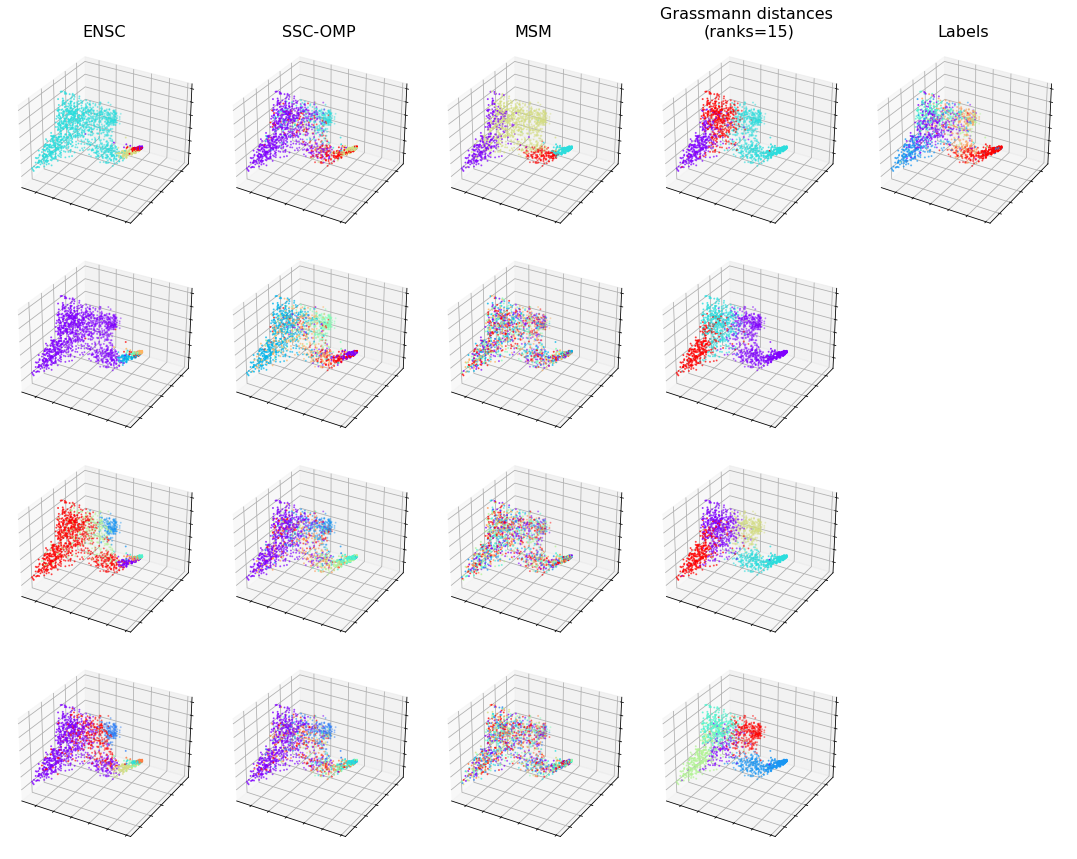

In [70]:
f,axs=plt.subplots(4,5,figsize=(15,12),sharex=True,sharey=True,subplot_kw=dict(projection='3d'))
axs=axs.T
for i,n_clusters in enumerate(np.arange(4,8)):
    axs[0,i].scatter(*X_diffmap[:],s=1,c=clus_ensc[n_clusters],cmap='rainbow')
    axs[1,i].scatter(*X_diffmap[:],s=1,c=clus_ssc_omp[n_clusters],cmap='rainbow')
    axs[2,i].scatter(*X_diffmap[:],s=1,c=clus_msm[n_clusters],cmap='rainbow')
    axs[3,i].scatter(*X_diffmap[:],s=1,c=clus_agg_smooth[n_clusters],cmap='rainbow')
    if i==0:
        axs[4,i].scatter(*X_diffmap[:],s=1,c=adata_reordered.obs['num_label'],cmap='rainbow')
    else:
        axs[4,i].axis('off')

for rax in axs:
    for ax in rax:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])

axs[0,0].set_title('ENSC',fontsize=16)
axs[1,0].set_title('SSC-OMP',fontsize=16)
axs[2,0].set_title('MSM',fontsize=16)
axs[3,0].set_title("Grassmann distances \n(ranks=15)",fontsize=16)
axs[4,0].set_title("Labels",fontsize=16)

plt.tight_layout()
plt.savefig('../../git/PHD_THESIS/images/Local dimensionality/subspace_clustering_nestorowa.png',bbox_inches="tight",dpi=300)
plt.show()

In [102]:
clus_hidalgo = {}
for i,n_clusters in enumerate(np.arange(4,8)):
    clus_hidalgo[n_clusters] = %R -i X -i n_clusters -o x x = intRinsic::Hidalgo(X,K=n_clusters)

Computing ratios and Nq...
Done! 
Initializing the algorithm... 
Done! 
Computing recurring quantities to save you time... 
Done! 
MCMC progress:
  |======================================================================| 100%
Posterior sampling complete. Postprocessing the chains...
Done! 

Computing ratios and Nq...
Done! 
Initializing the algorithm... 
Done! 
Computing recurring quantities to save you time... 
Done! 
MCMC progress:
  |======================================================================| 100%
Posterior sampling complete. Postprocessing the chains...
Done! 

Computing ratios and Nq...
Done! 
Initializing the algorithm... 
Done! 
Computing recurring quantities to save you time... 
Done! 
MCMC progress:
  |======================================================================| 100%
Posterior sampling complete. Postprocessing the chains...
Done! 

Computing ratios and Nq...
Done! 
Initializing the algorithm... 
Done! 
Computing recurring quantities to save you time... 


In [ ]:
X2,l = skdim.datasets.lineDiskBall(2000,random_state=0)
clus_hidalgo2 = {}
for i,n_clusters in enumerate(np.arange(4,8)):
    clus_hidalgo2[n_clusters] = %R -i X2 -i n_clusters -o x x = intRinsic::Hidalgo(X2,K=n_clusters)

Computing ratios and Nq...
Done! 
Initializing the algorithm... 
Done! 
Computing recurring quantities to save you time... 
Done! 
MCMC progress:
  |======================================================================| 100%
Posterior sampling complete. Postprocessing the chains...
Done! 

Computing ratios and Nq...
Done! 
Initializing the algorithm... 
Done! 
Computing recurring quantities to save you time... 
Done! 
MCMC progress:
  |======================================================================| 100%
Posterior sampling complete. Postprocessing the chains...
Done! 

Computing ratios and Nq...
Done! 
Initializing the algorithm... 
Done! 
Computing recurring quantities to save you time... 
Done! 
MCMC progress:
  |======================================================================| 100%
Posterior sampling complete. Postprocessing the chains...
Done! 

Computing ratios and Nq...
Done! 
Initializing the algorithm... 
Done! 
Computing recurring quantities to save you time... 


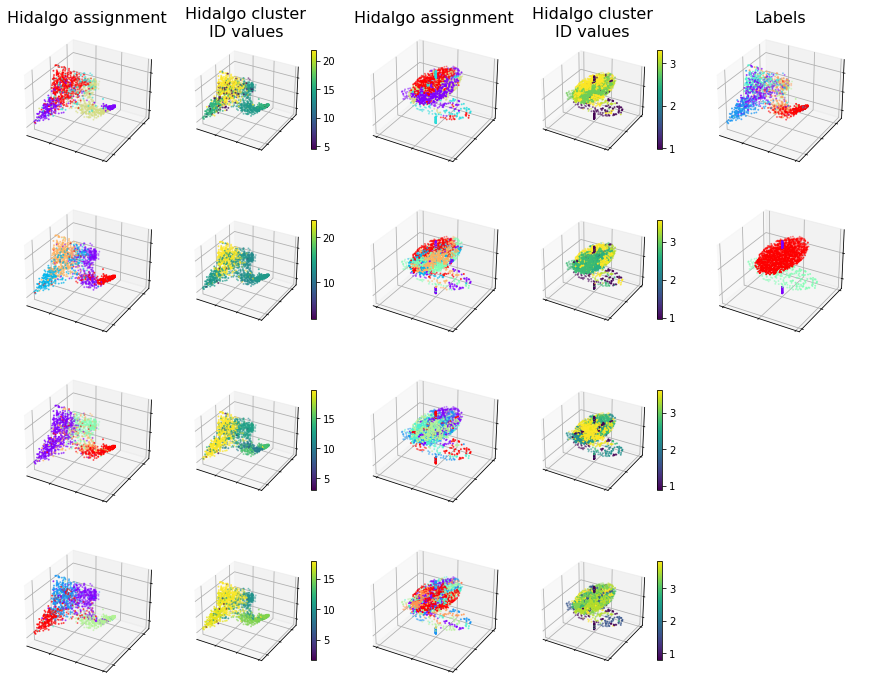

In [135]:
f,axs=plt.subplots(4,5,figsize=(15,12),subplot_kw=dict(projection='3d'))
axs=axs.T

for i,n_clusters in enumerate(np.arange(4,8)):
    axs[0,i].scatter(*X_diffmap,s=1,c=np.array(clus_hidalgo[n_clusters][1])[-1],cmap='rainbow')
    _=axs[1,i].scatter(*X_diffmap,s=1,c=np.array(clus_hidalgo[n_clusters][3])[0])
    plt.colorbar(_,ax=axs[1,i],shrink=0.7)
    
    axs[2,i].scatter(*X2.T,s=1,c=np.array(clus_hidalgo2[n_clusters][1])[-1],cmap='rainbow')
    _=axs[3,i].scatter(*X2.T,s=1,c=np.array(clus_hidalgo2[n_clusters][3])[0])
    plt.colorbar(_,ax=axs[3,i],shrink=0.7)

    if i==0:
        axs[4,i].scatter(*X_diffmap,s=1,c=adata_reordered.obs['num_label'],cmap='rainbow')
    elif i==1:
        axs[4,i].scatter(*X2.T,s=1,c=l,cmap='rainbow')
    else:
        axs[4,i].axis('off')

for rax in axs:
    for ax in rax:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])

axs[0,0].set_title('Hidalgo assignment',fontsize=16)
axs[1,0].set_title('Hidalgo cluster\nID values',fontsize=16)
axs[2,0].set_title('Hidalgo assignment',fontsize=16)
axs[3,0].set_title('Hidalgo cluster\nID values',fontsize=16)
axs[4,0].set_title("Labels",fontsize=16)
plt.tight_layout()
plt.savefig('../../git/PHD_THESIS/images/Local dimensionality/Hidalgo_clustering_nestorowa.png',bbox_inches="tight",dpi=300)
plt.show()

In [61]:
dist,knnidx = skdim.get_nn(X_pca[:,:50],50,n_jobs=4)
lid,smooth_lid = skdim.id.FisherS().fit_transform_pw(X_pca[:,:50],n_neighbors=50,smooth=True,
                                                           precomputed_knn=knnidx)
X2,l = skdim.datasets.lineDiskBall(2000,random_state=0)
dist2,knnidx2 = skdim.get_nn(X2,25,n_jobs=4)
lid2,smooth_lid2 = skdim.id.FisherS().fit_transform_pw(X2,n_neighbors=25,smooth=True,
                                                           precomputed_knn=knnidx2)

A = skdim.get_nn(X_pca[:,:50],k=50,sparse=True)
A2 = skdim.get_nn(X2,k=25,sparse=True)

In [62]:
A = skdim.get_nn(X_pca[:,:50],k=10,sparse=True)
A2 = skdim.get_nn(X2,k=10,sparse=True)

In [63]:
clus_cp = {}
clus_cp2 = {}

for i in [.1,.25,.5,1]:
    cp = skdim.cluster.CutPursuit(A,mode='l1',loss=1,edge_weights=i).fit(smooth_lid.astype('float32'))
    clus_cp[i]=(cp.components_,cp.components_values_[cp.components_].flatten())
    
    cp = skdim.cluster.CutPursuit(A2,mode='l1',loss=1,edge_weights=i).fit(smooth_lid2.astype('float32'))
    clus_cp2[i]=(cp.components_,cp.components_values_[cp.components_].flatten())

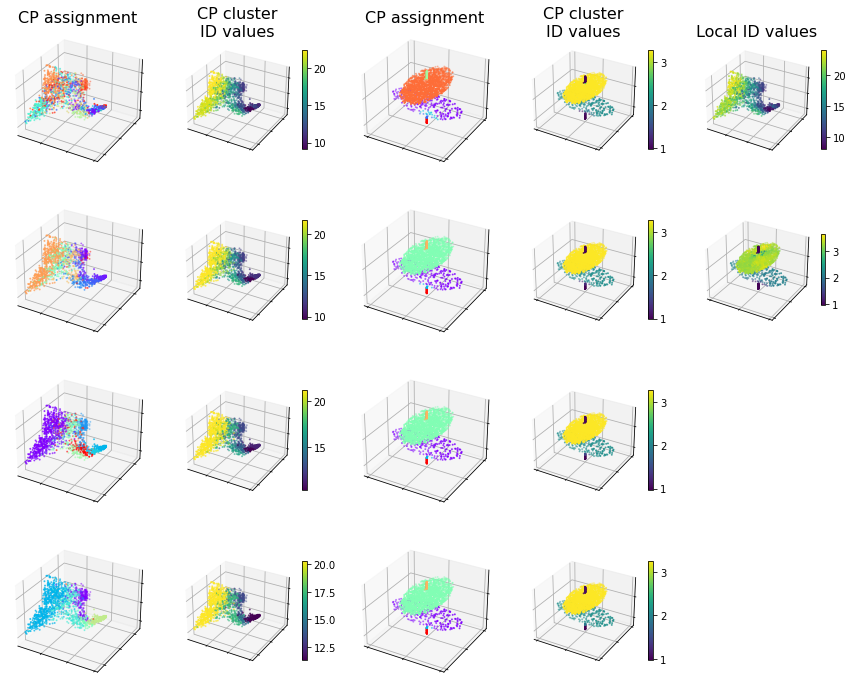

In [76]:
f,axs=plt.subplots(4,5,figsize=(15,12),subplot_kw=dict(projection='3d'))
axs=axs.T

for i,res in enumerate([.1,.25,.5,1]):
    axs[0,i].scatter(*X_diffmap,s=1,c=clus_cp[res][0],cmap='rainbow')
    _=axs[1,i].scatter(*X_diffmap,s=1,c=clus_cp[res][1])
    plt.colorbar(_,ax=axs[1,i],shrink=0.7)
    
    axs[2,i].scatter(*X2.T,s=1,c=clus_cp2[res][0],cmap='rainbow')
    _=axs[3,i].scatter(*X2.T,s=1,c=clus_cp2[res][1])
    plt.colorbar(_,ax=axs[3,i],shrink=0.7)
    if i > 1:
        axs[4,i].axis('off')

_=axs[4,0].scatter(*X_diffmap,s=1,c=smooth_lid)
plt.colorbar(_,ax=axs[4,0],shrink=0.7)
_=axs[4,1].scatter(*X2.T,s=1,c=smooth_lid2)
plt.colorbar(_,ax=axs[4,1],shrink=0.5)

for rax in axs:
    for ax in rax:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])

axs[0,0].set_title('CP assignment',fontsize=16)
axs[1,0].set_title('CP cluster\nID values',fontsize=16)
axs[2,0].set_title('CP assignment',fontsize=16)
axs[3,0].set_title('CP cluster\nID values',fontsize=16)
axs[4,0].set_title("Local ID values",fontsize=16)
plt.tight_layout()
plt.savefig('../../git/PHD_THESIS/images/Local dimensionality/CP_clustering_nestorowa.png',bbox_inches="tight",dpi=300)
plt.show()